In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scglue
import anndata as ad

import matplotlib as mpl
from matplotlib import cm
from matplotlib import pyplot as plt
import seaborn as sns
import os
from itertools import cycle

%matplotlib inline

sns.set_style('ticks')
mpl.rcParams['figure.figsize'] = [4, 4]
mpl.rcParams['figure.dpi'] = 100

sc.set_figure_params(figsize=(4,4),dpi=120)

# Single-cell integrations to test the validity

In [2]:
path = '/lustre/scratch/kiviaho/spatac/integrations/tonsilatlas/single_cell_all/results'
os.chdir(path)

In [3]:
# DOWNLOAD DATA
rna = sc.read_h5ad('rna-20221214-with-glue-embeddings.h5ad')
atac = sc.read_h5ad('atac-20221214-with-glue-embeddings.h5ad')
glue = scglue.models.load_model('glue-model-20221214.dill')

# Add common column key to plot with
rna.obs['domain'] = 'rna'
atac.obs['domain'] = 'atac'

[INFO] autodevice: Using CPU as computation device.


In [4]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)
combined = ad.concat([rna, atac])
combined.obs['broad_celltype'] = combined.obs['broad_celltype'].astype('category')

/home/ak431480/.conda/envs/spatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


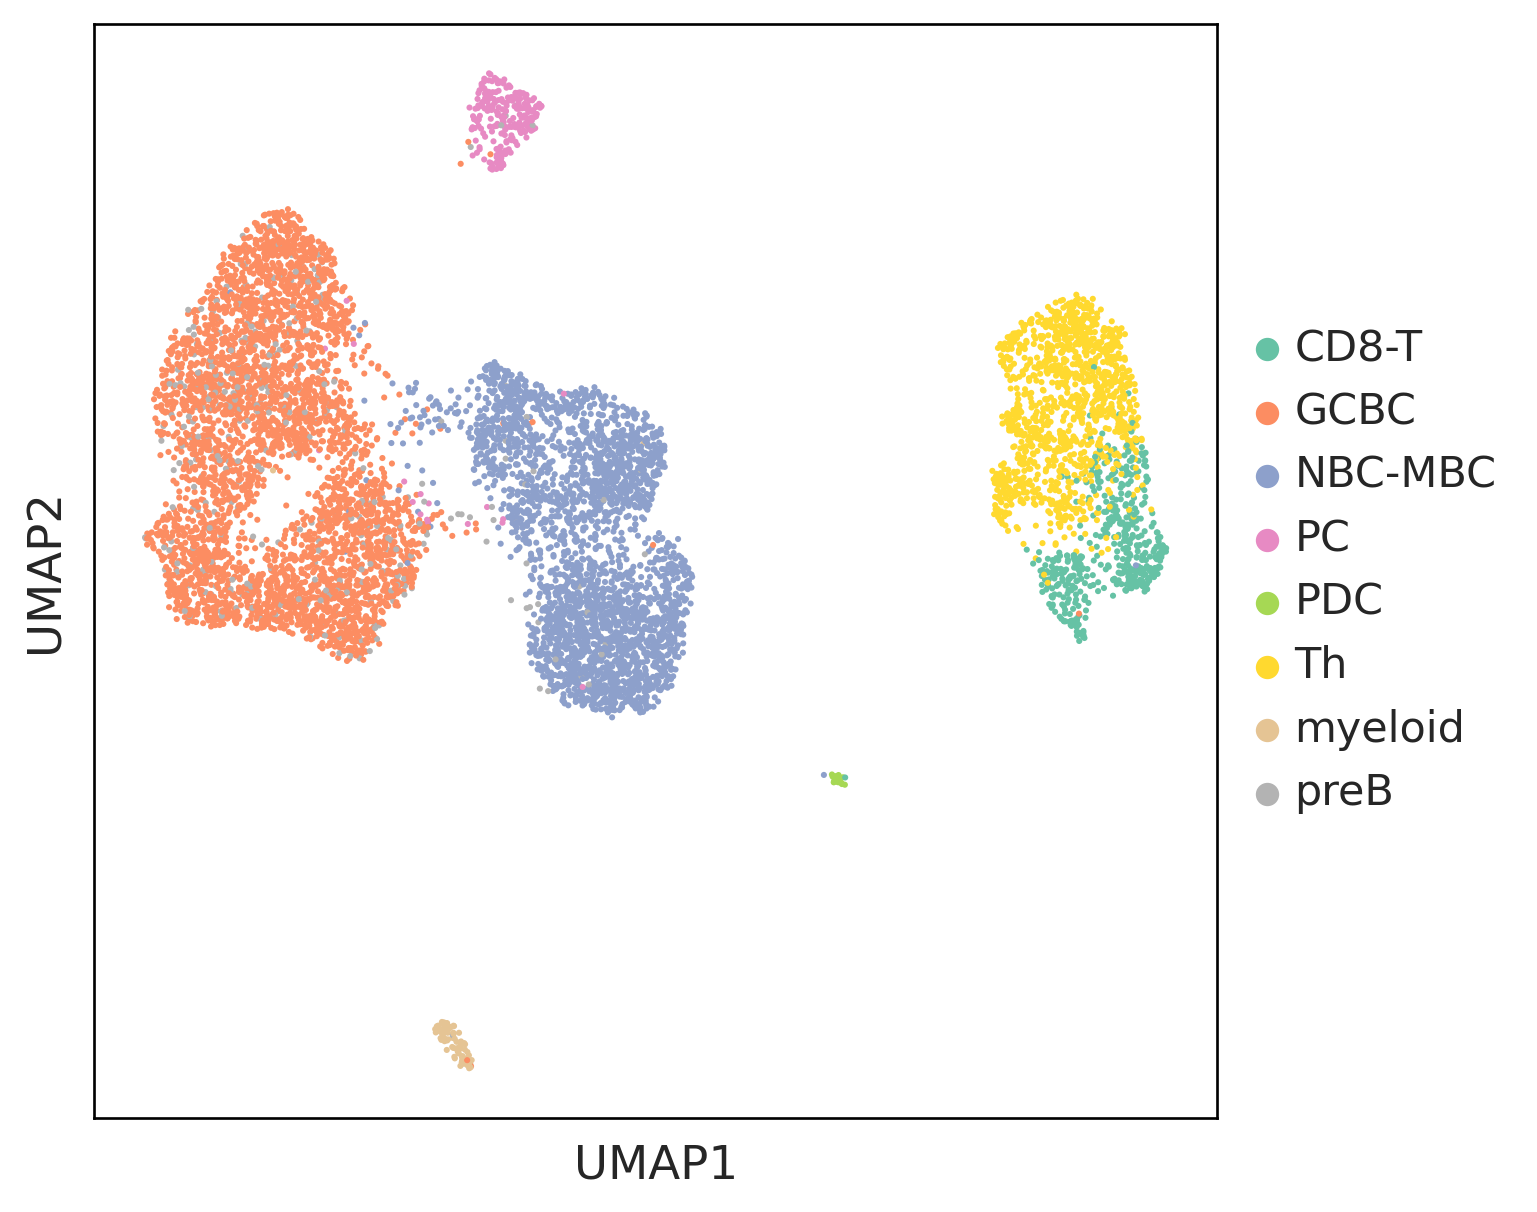

In [11]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(6,6)
fig.set_dpi(120)
sc.pl.umap(combined,color='broad_celltype',title='',ax=ax1)


In [9]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(4,4)
sc.pl.umap(combined,color='broad_celltype',title='',ax=ax1,legend_loc='none',frameon=False,show=False)
plt.savefig('/lustre/scratch/kiviaho/spatac/plots/tonsil-combined-scatter-with-broad-celltype.png',dpi=600)
plt.clf()

<Figure size 480x480 with 0 Axes>

In [ ]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(6,6)
fig.set_dpi(120)
sc.pl.umap(combined,color='domain',title='',ax=ax1,palette='Set2')


In [ ]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(4,4)
sc.pl.umap(combined,color='domain',title='',ax=ax1,legend_loc='none',frameon=False,show=False,palette='Set2')
plt.savefig('/lustre/scratch/kiviaho/spatac/plots/tonsil-combined-scatter-with-domain.png',dpi=600)
plt.clf()

In [8]:
data_umap = combined.obsm['X_umap']
metadata = pd.DataFrame({'umap_x': data_umap[:,0],
                         'umap_y':data_umap[:,1],
                         'Label': combined.obs['broad_celltype'],
                         'domain': combined.obs['domain']})

metadata = metadata.sort_values(['Label'])
metadata['Label'] = metadata['Label'].astype(str)

## Sampled broad celltypes

In [6]:
path = '/lustre/scratch/kiviaho/spatac/integrations/tonsilatlas/sampled_broad_celltypes_all/'
os.chdir(path)

# DOWNLOAD DATA
# Changed the loaded data, GLUE dims can be acquired by running the encoding lines below!
rna = ad.read_h5ad(path+'preprocessed_synthetic_spatial_rna_20221215.h5ad')
atac = ad.read_h5ad(path+'preprocessed_simulated_spots_atac_20221215.h5ad')
glue = scglue.models.load_model(path+'results/glue-model-20221215.dill')

# Add common column key to plot with
rna.obs['domain'] = 'rna'
atac.obs['domain'] = 'atac'

rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [7]:
rna

AnnData object with n_obs × n_vars = 10000 × 23514
    obs: 'GCBC', 'NBC-MBC', 'preB', 'CD8-T', 'Th', 'PDC', 'PC', 'myeloid', 'domain'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'tag', 'hgnc_id', 'havana_gene', 'highly_variable_rank', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'cell_barcodes', 'X_glue'
    varm: 'PCs'
    layers: 'counts'

In [23]:
atac

AnnData object with n_obs × n_vars = 49555 × 146076
    obs: 'GCBC', 'NBC-MBC', 'preB', 'CD8-T', 'Th', 'PDC', 'PC', 'myeloid', 'domain'
    var: 'chrom', 'chromStart', 'chromEnd', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N', 'highly_variable'
    obsm: 'X_lsi', 'cell_barcodes', 'X_glue'
    layers: 'counts'

In [24]:
import time
n_neighbors = 5

start = time.time()
rna_glue = rna.obsm['X_glue']
atac_glue = atac.obsm['X_glue']

inferred_counts = np.empty((0,8),dtype=float)

for a_idx in range(len(rna_glue)):
    # Repeats the same vector to match the size of atac_glue
    a = np.tile(rna_glue[a_idx],(atac_glue.shape[0],1))
    # Calculate the euclidean distance in GLUE space between each 'spot'
    distances = np.linalg.norm(a-atac_glue,axis=1)

    # Extract indices of n nearest matches
    nearest_matches = np.array(distances).argsort()[:n_neighbors]
    # Extract the cell counts and calculate their mean
    inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean())])
time.time() - start

/tmp/ipykernel_3089/4094941691.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  inferred_counts = np.vstack([inferred_counts,np.array(atac[nearest_matches].obs.mean())])


504.78893876075745

In [26]:
inferred_counts.shape

(10000, 8)

In [25]:
rna

AnnData object with n_obs × n_vars = 10000 × 23514
    obs: 'GCBC', 'NBC-MBC', 'preB', 'CD8-T', 'Th', 'PDC', 'PC', 'myeloid', 'domain'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'tag', 'hgnc_id', 'havana_gene', 'highly_variable_rank', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'cell_barcodes', 'X_glue'
    varm: 'PCs'
    layers: 'counts'

In [27]:
inferred_spot_cell_counts = pd.DataFrame(inferred_counts, 
                             columns=rna.obs.columns[:inferred_counts.shape[1]],
                             index=rna.obs.index)
inferred_spot_cell_counts = np.round(inferred_spot_cell_counts)
cell_count_df = rna.obs.iloc[:,0:8]

In [123]:
def plot_spatial(values, n=[50,50], nrows=5, names=['cell type'],
                 vmin=0, vmax=[1],use_vmax= False):
    
    n_cell_types = values.shape[1]
    n1, n2 = n 
    ncols = int(np.ceil((n_cell_types+1) / nrows))
    for ct in range(n_cell_types):
        if use_vmax:
            vmax_n = vmax[ct]
        else:
            vmax_n = max(values[:,ct])
        plt.subplot(nrows, ncols, ct+1)
        plt.imshow(values[:,ct].reshape(n1,n2).T, 
                   cmap=plt.cm.get_cmap('magma'),
                   vmin=vmin, vmax=vmax_n
                  )
        plt.axis('off')
        plt.colorbar(location='bottom')
        if len(names) > 1:
            plt.title(names[ct])
        else:
            plt.title(f'{names[0]} {ct+1}')

    plt.subplot(nrows, ncols, n_cell_types+1) 
    plt.imshow(values.sum(axis=1).reshape(n1,n2).T, 
               cmap=plt.cm.get_cmap('Greys'))
    plt.colorbar(location='bottom')
    plt.title('total')

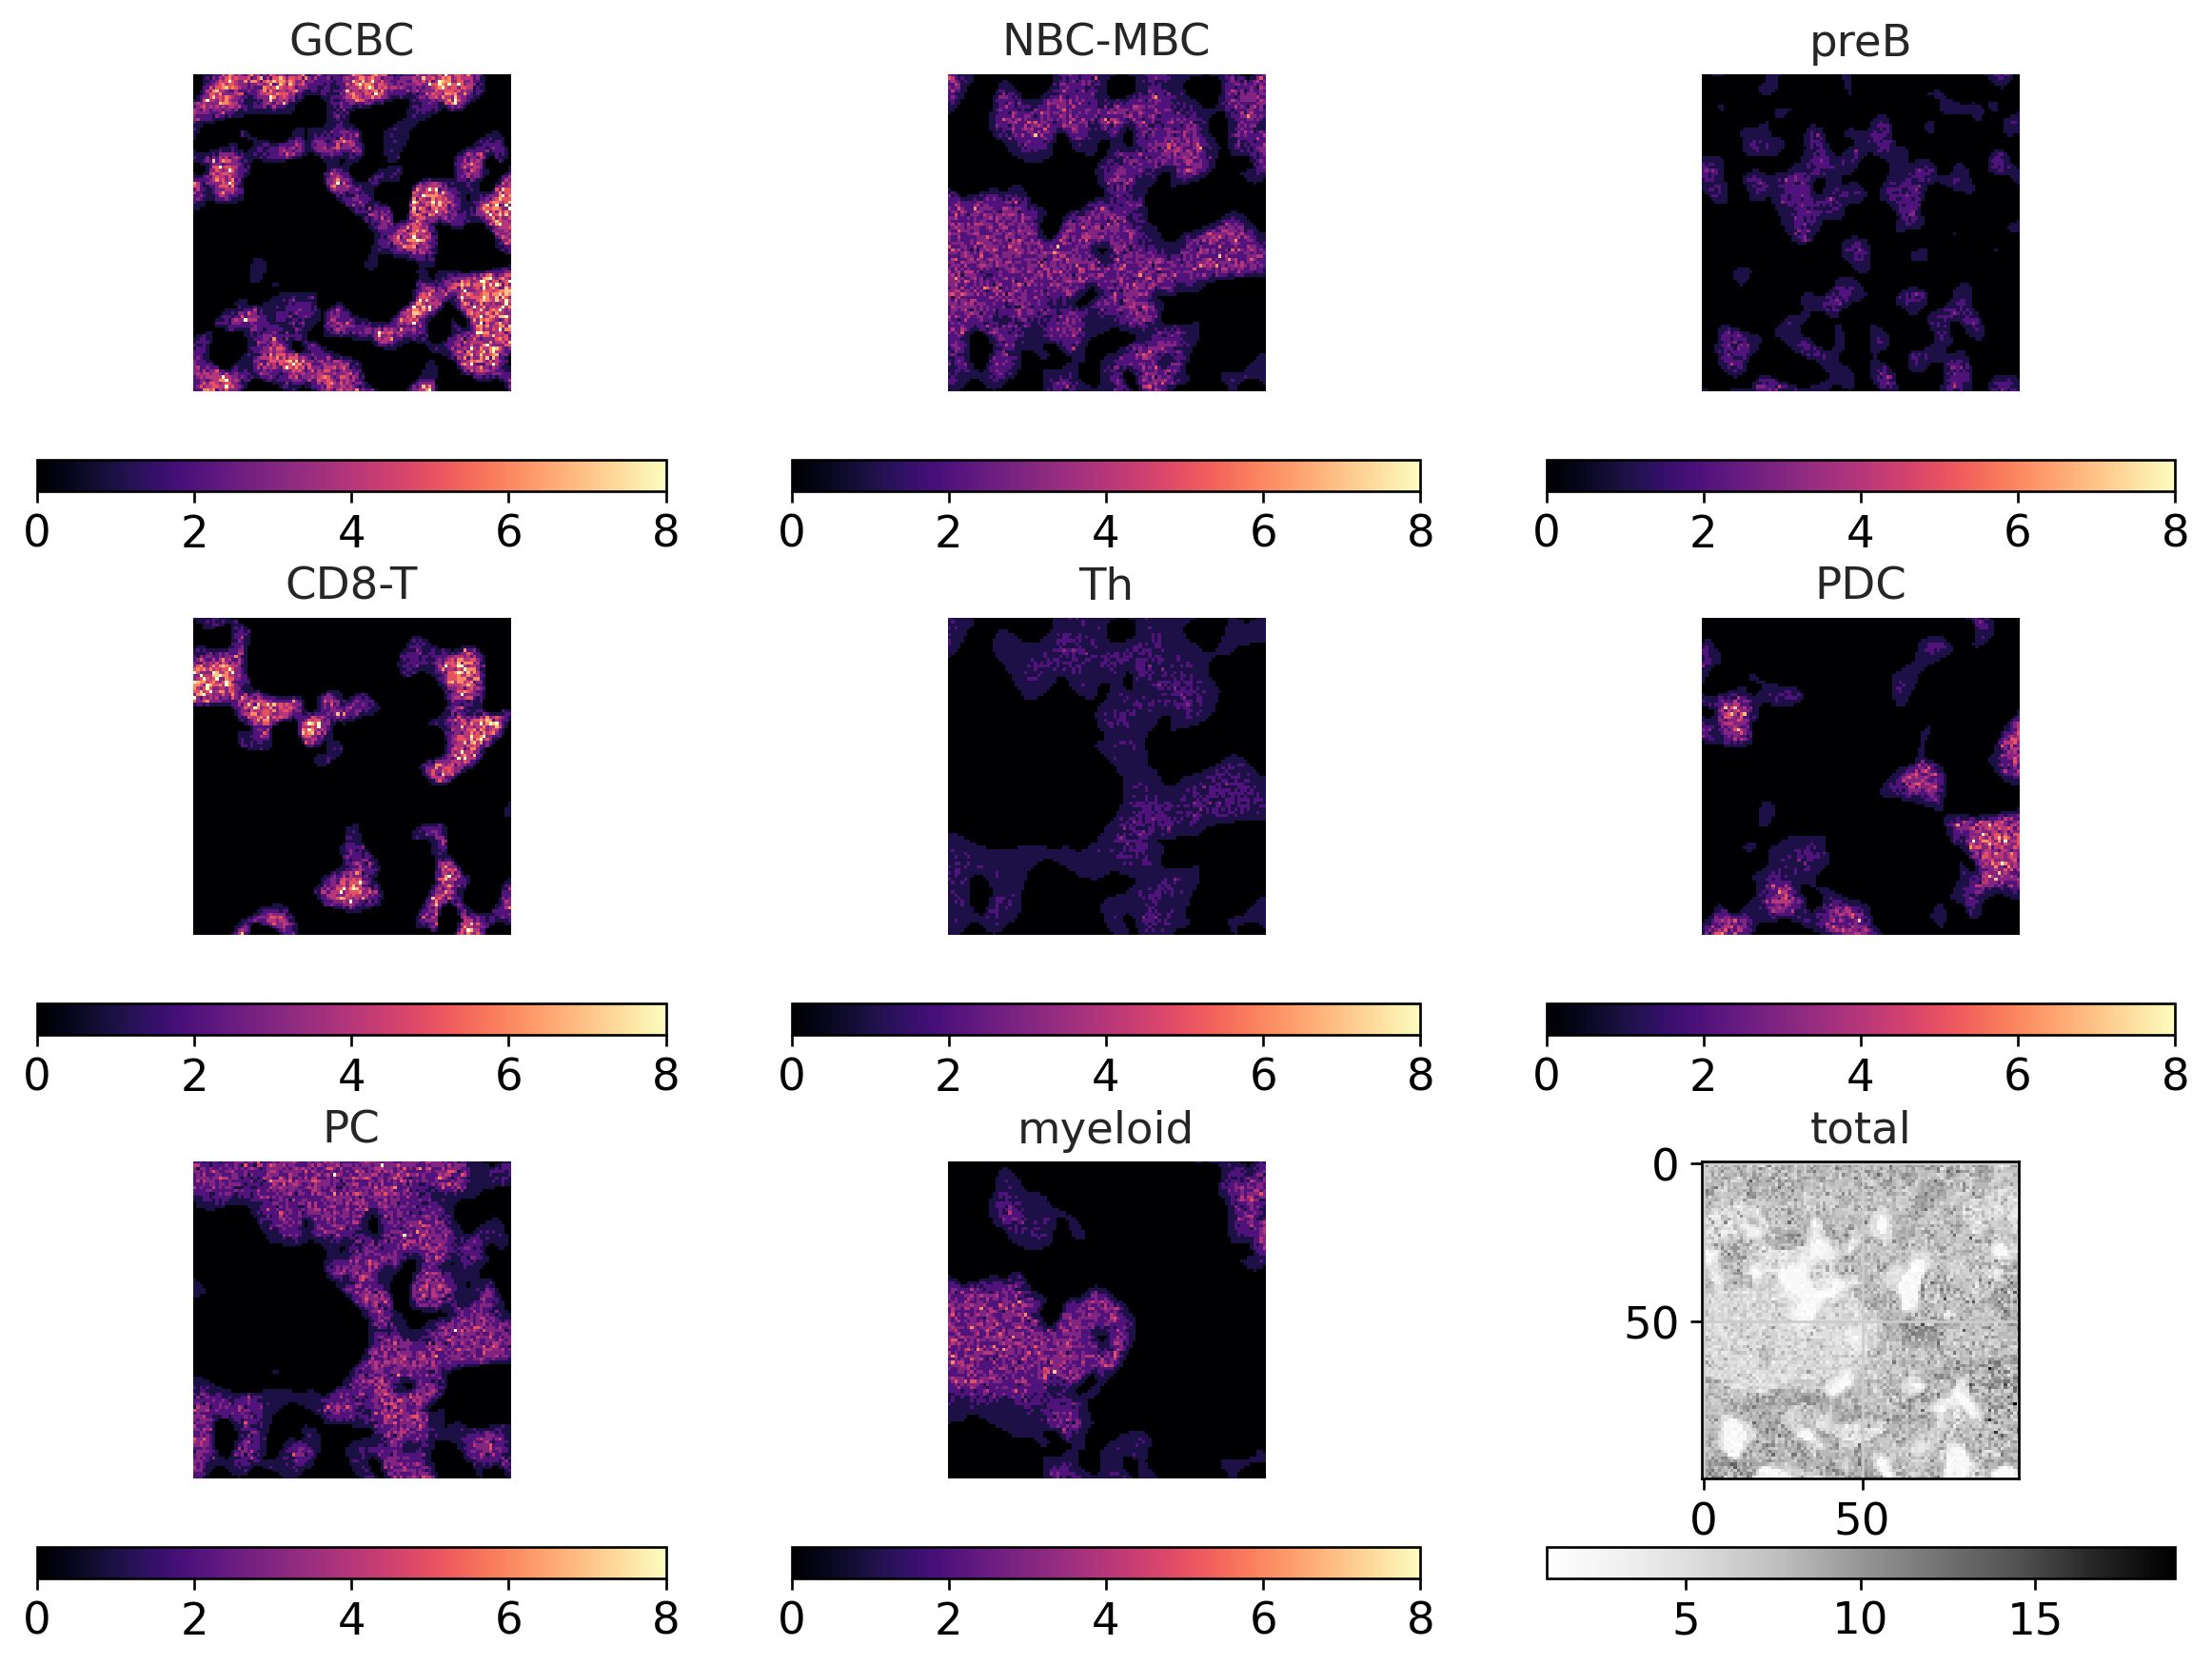

In [126]:
n_locations = [100, 100]
plt.figure(figsize=(12,12),dpi=120)
plot_spatial(cell_count_df.to_numpy(), 
             n=n_locations, nrows=4, 
             names=cell_count_df.columns,
             vmax=np.repeat(8,8),use_vmax=True)

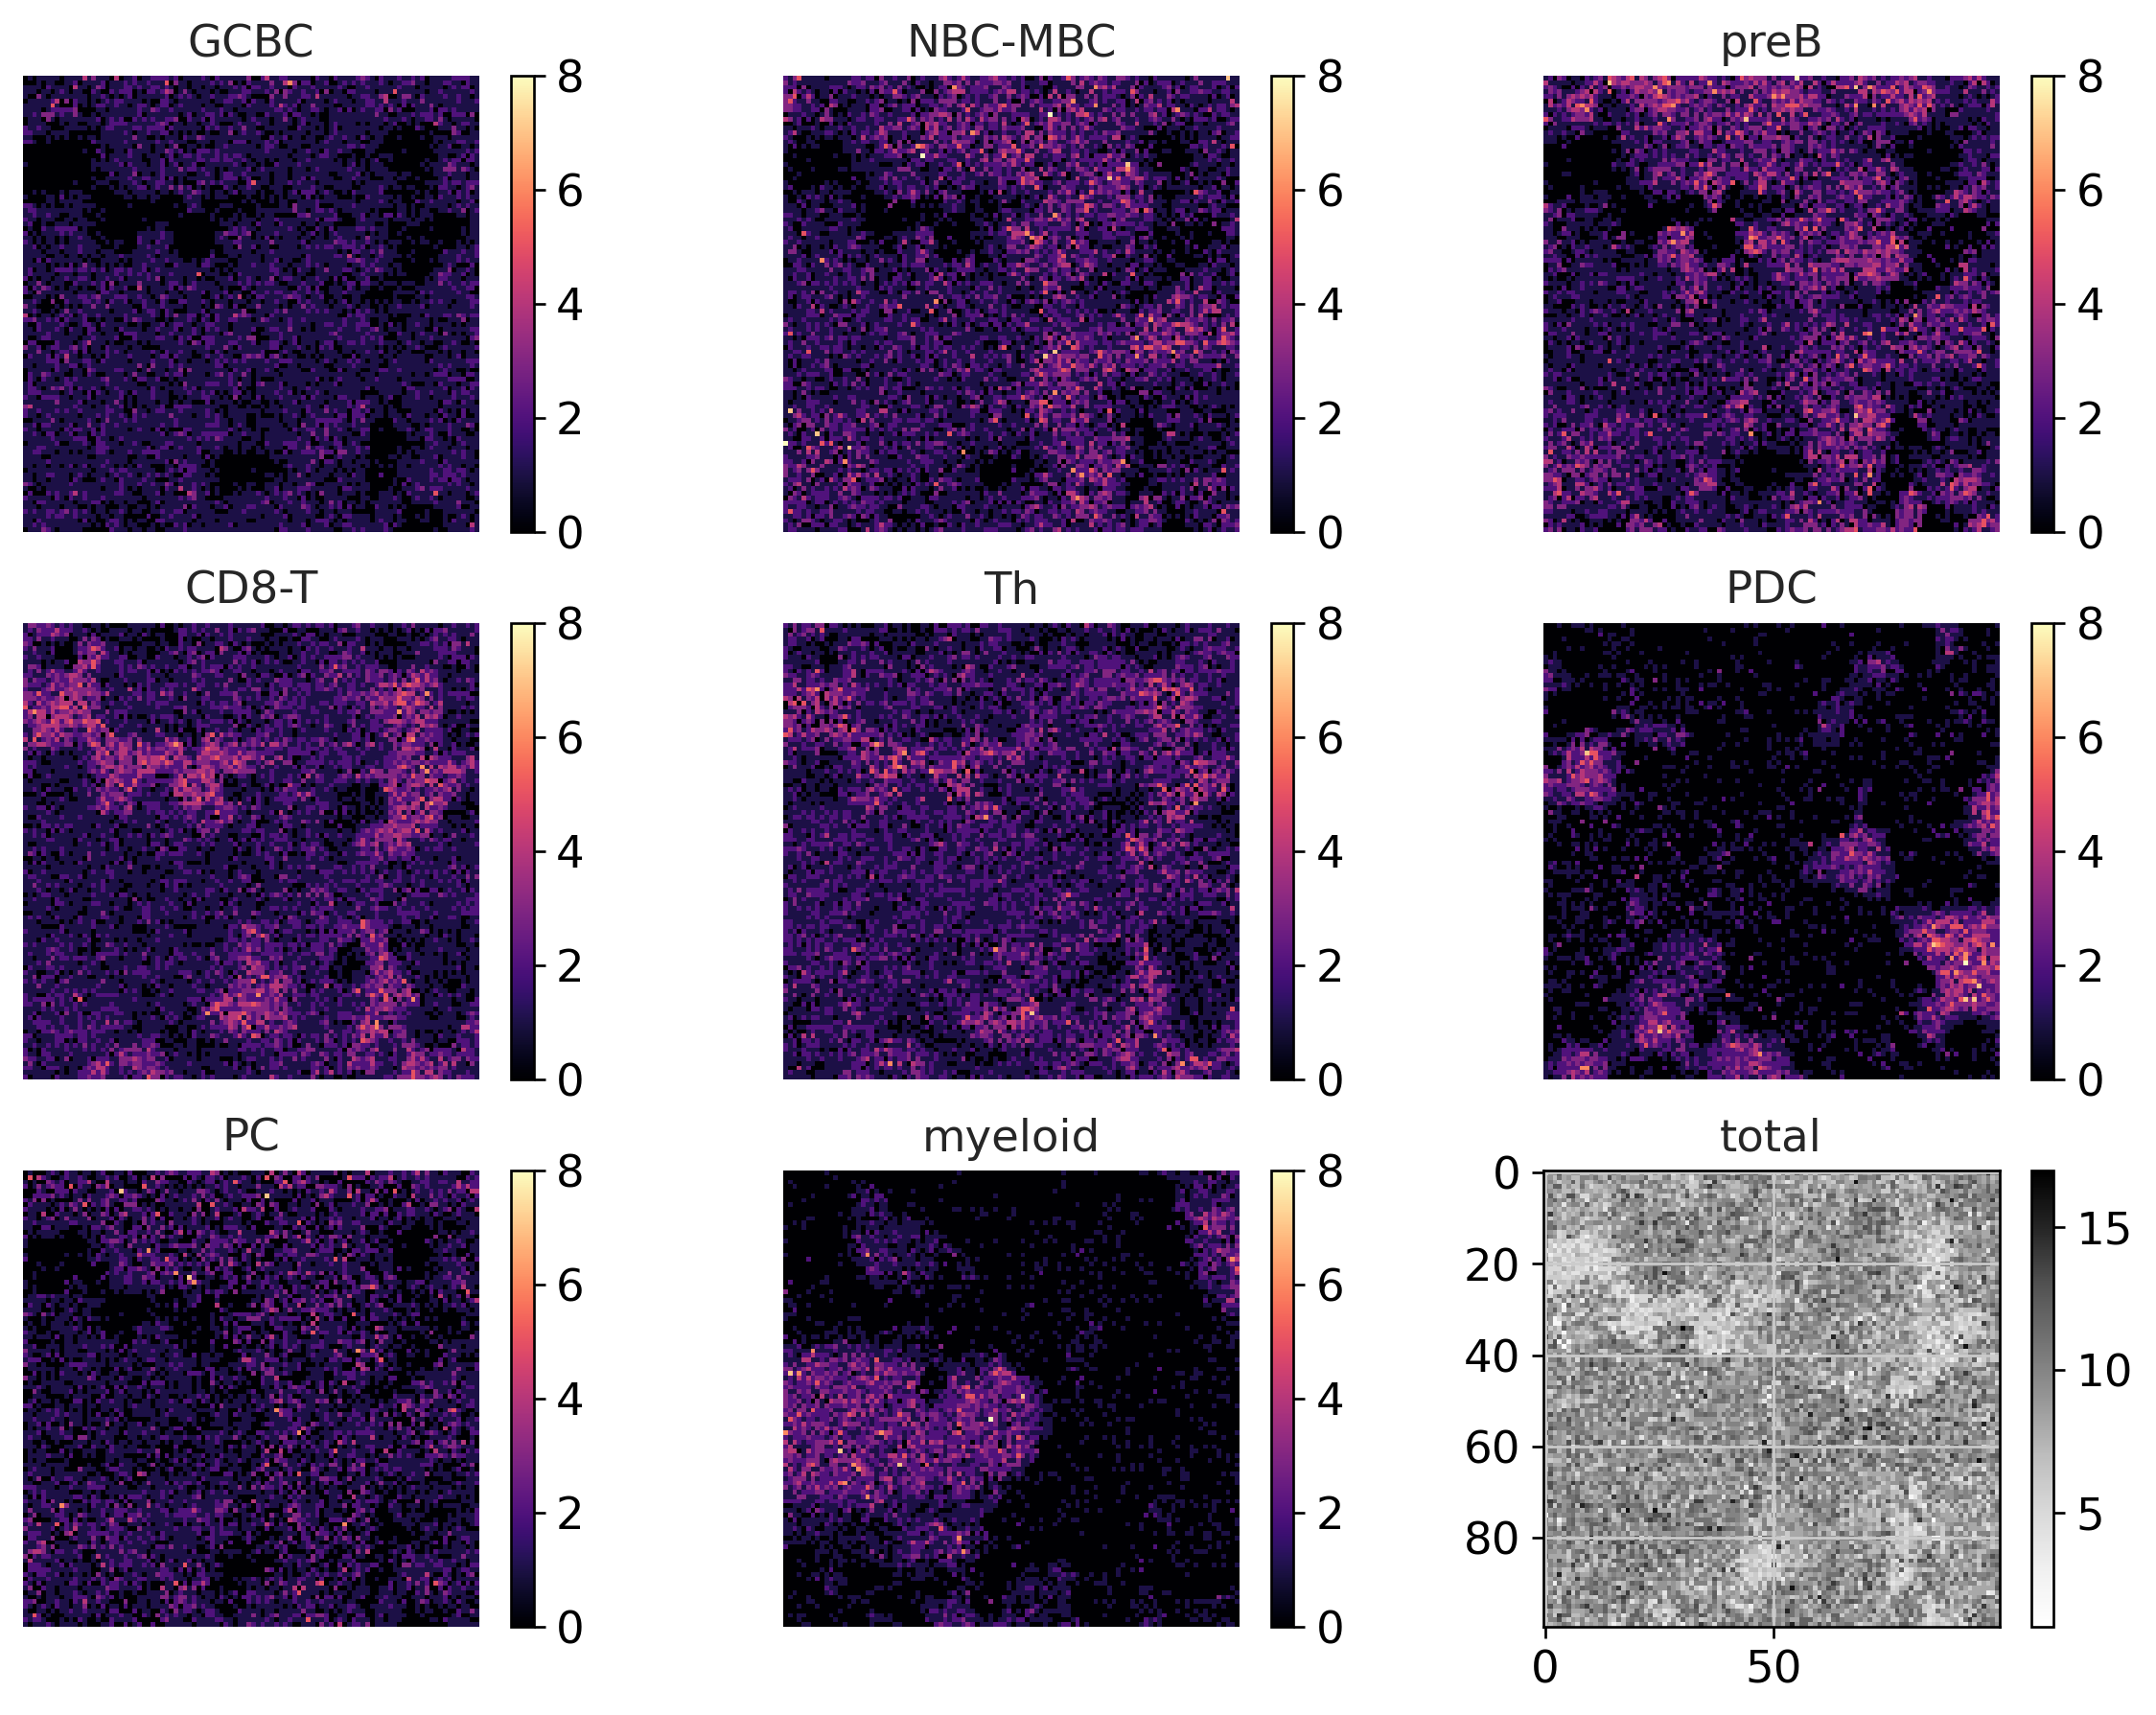

In [111]:
n_locations = [100, 100]
plt.figure(figsize=(12,12),dpi=120)
plot_spatial(np.floor(inferred_spot_cell_counts).to_numpy(), 
             n=n_locations, nrows=4, 
             names=inferred_spot_cell_counts.columns,
             vmax=np.repeat(8,8), use_vmax=True) # [14,7,4,11,3,8,9,7]

## Generating tissue heatmap plots for press

In [112]:
def plot_spatial_alt(values, n=[50,50], nrows=5, names=['cell type'],
                 vmin=0, vmax=1):
    
    n_cell_types = values.shape[1]
    n1, n2 = n 
    ncols = int(np.ceil((n_cell_types+1) / nrows))
    for i,ct in enumerate(range(n_cell_types)):
        plt.subplot(nrows, ncols, ct+1)
        plt.imshow(values[:,ct].reshape(n1,n2).T, 
                   cmap=plt.cm.get_cmap('magma'),
                   vmin=vmin, vmax=vmax[i]
                  )
        plt.axis('off')

    plt.subplot(nrows, ncols, n_cell_types+1) 
    plt.imshow(values.sum(axis=1).reshape(n1,n2).T, 
               cmap=plt.cm.get_cmap('Greys'))
    plt.axis('off')
    plt.tight_layout()


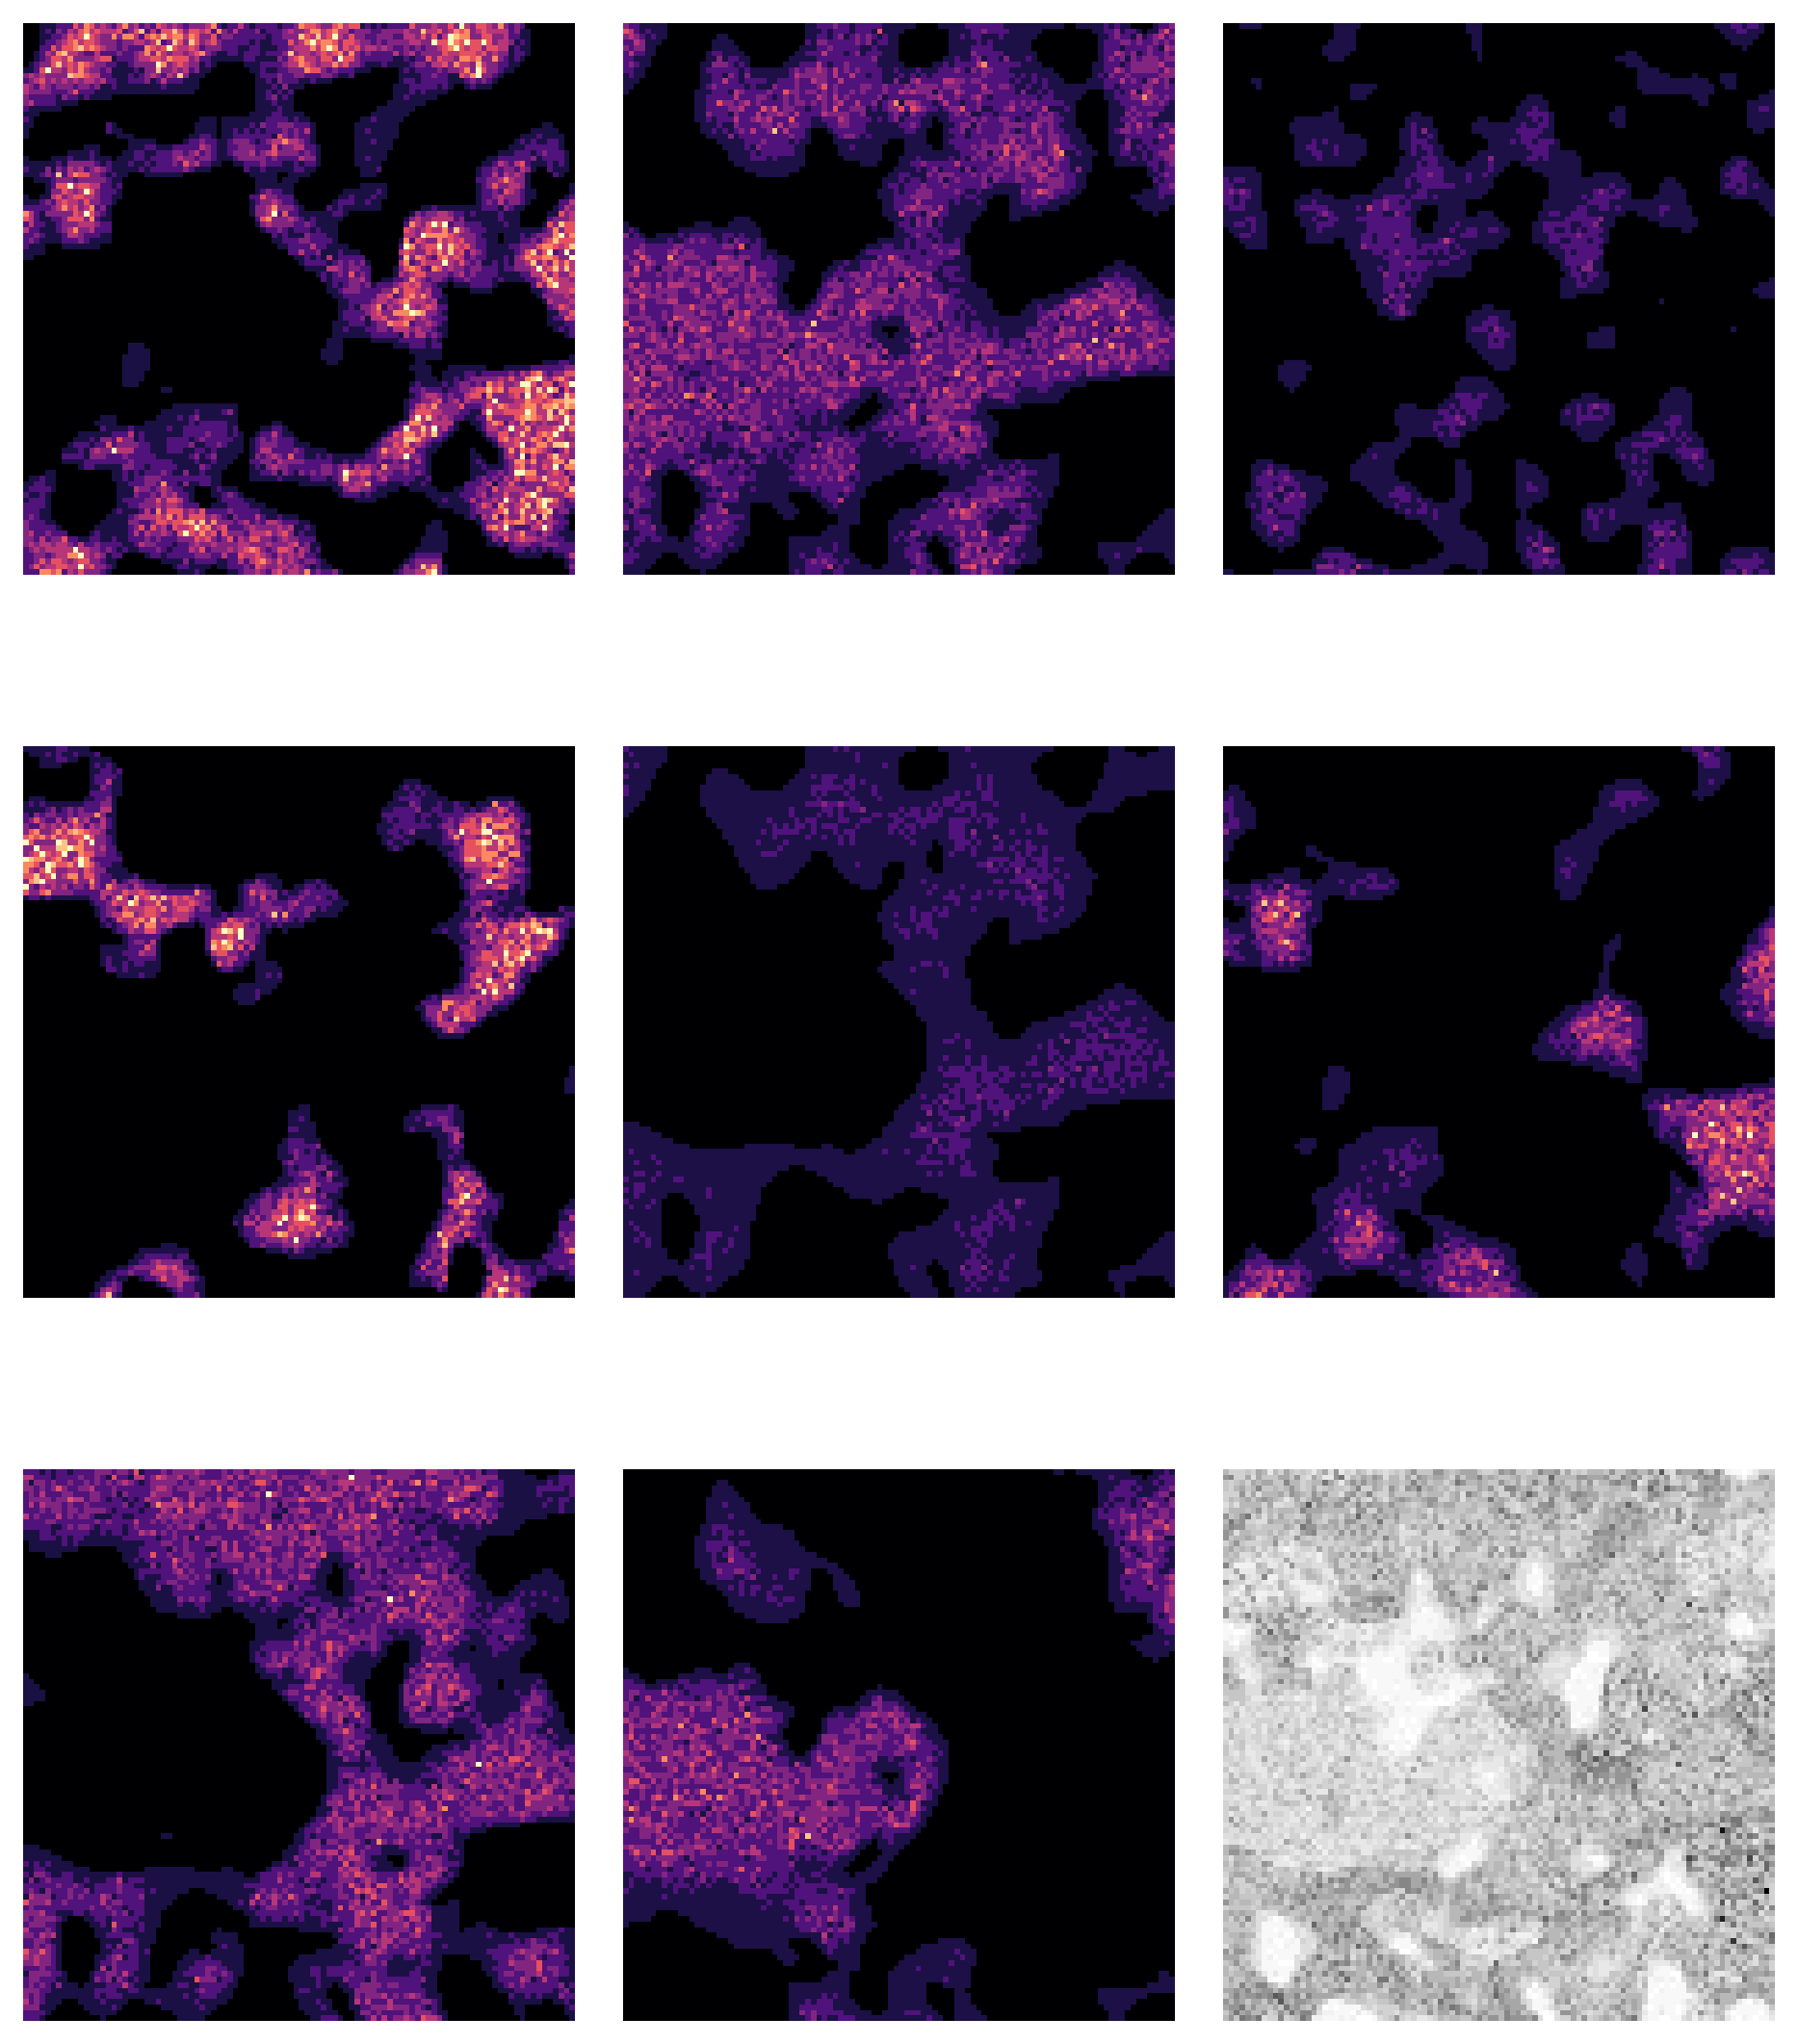

In [115]:
n_locations = [100, 100]
plt.figure(figsize=(8,10),dpi=120)
plot_spatial_alt(cell_count_df.values, 
             n=n_locations, nrows=3, 
             names=cell_count_df.columns, vmax=np.repeat(8,8)) # [14,7,4,11,3,8,9,7]
plt.savefig('../../../plots/tonsilatlas_celltype_distribution_ground_truth.png',dpi=600)

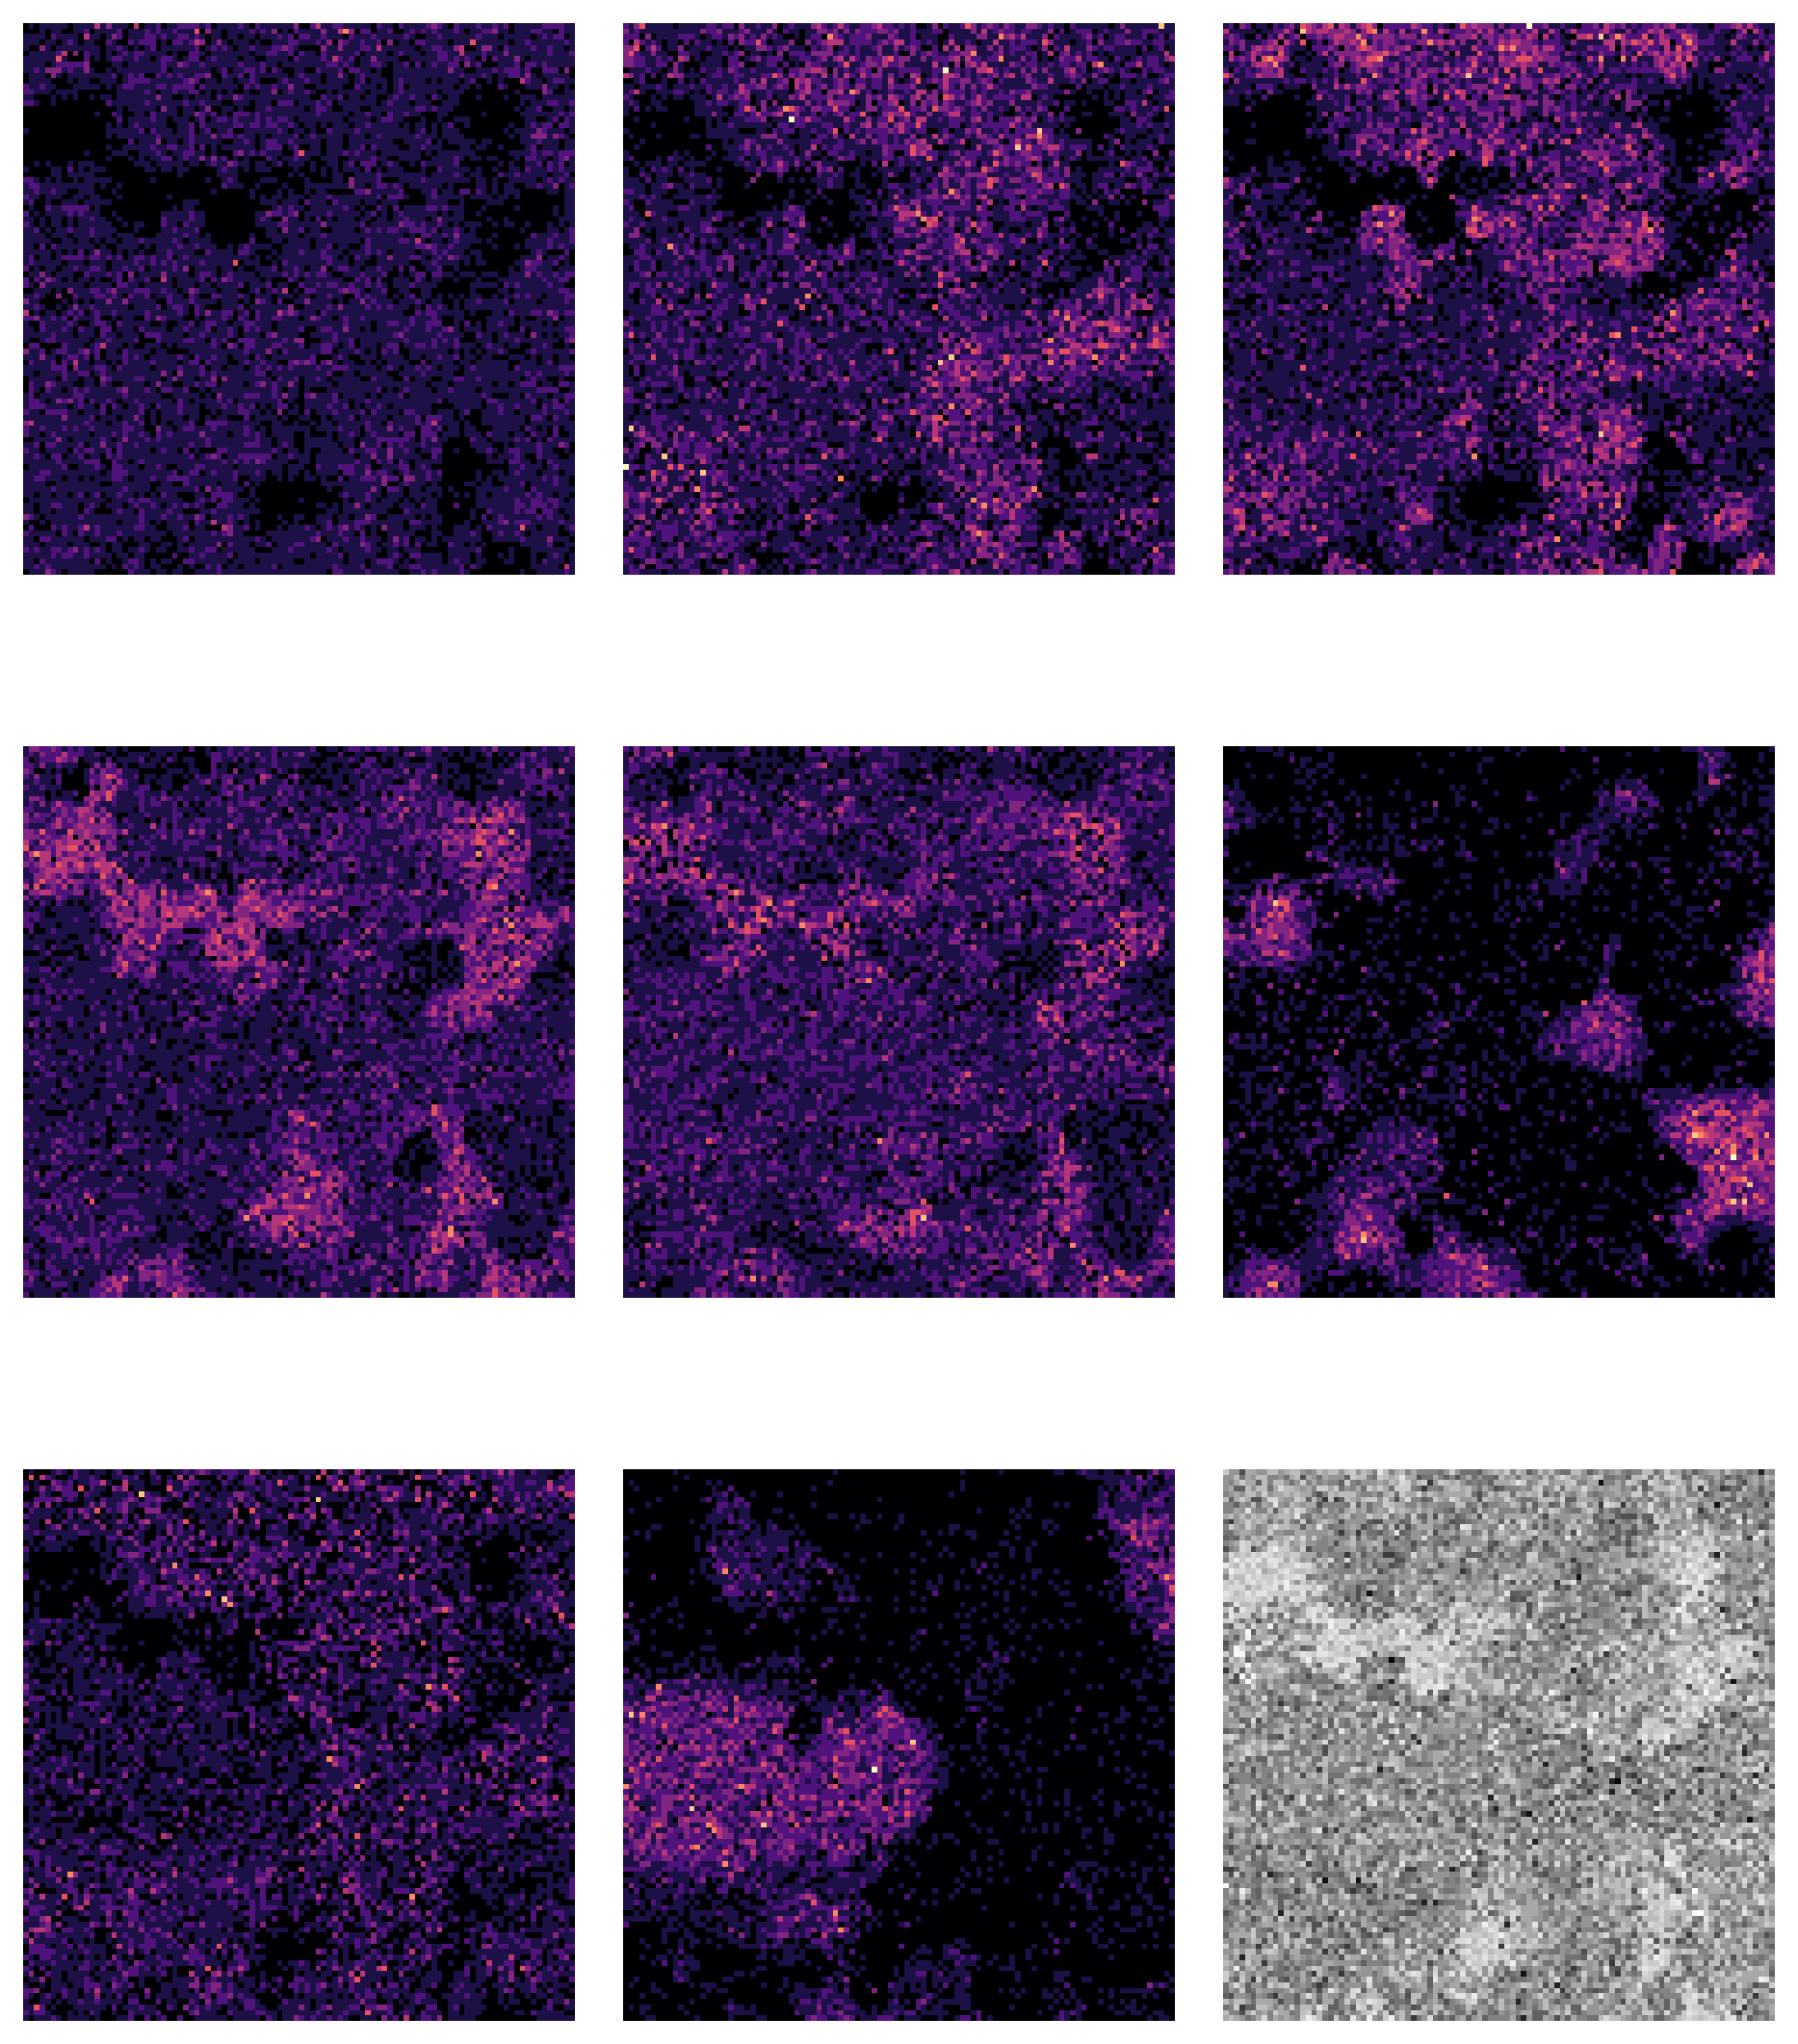

In [116]:
n_locations = [100, 100]
plt.figure(figsize=(8,10),dpi=120)
plot_spatial_alt(inferred_spot_cell_counts.values, 
             n=n_locations, nrows=3, 
             names=inferred_spot_cell_counts.columns, vmax=np.repeat(8,8)) 
plt.savefig('../../../plots/tonsilatlas_celltype_distribution_inferred_cell_counts.png',dpi=600) # [14,7,4,11,3,8,9,7]